In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
Base.prepare(engine, reflect=True)


# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station=Base.classes.station 
Measurement=Base.classes.measurement


In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)


# Exploratory Climate Analysis

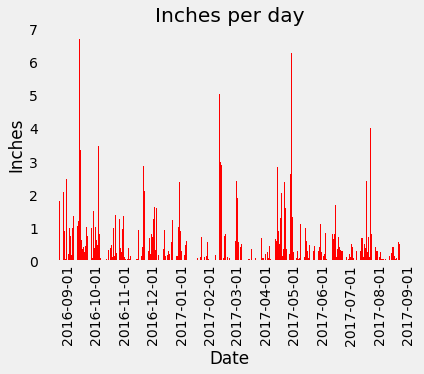

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
Last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#s = time.strftime(f'{Last_date}', time.gmtime(time.time()))
a_date=dt.datetime.strptime(Last_date,"%Y-%m-%d").date()
days=dt.timedelta(365)
end_date=a_date-days
end_date
end_d= '{:%Y-%m-%d}'.format(end_date)
end_d

# Perform a query to retrieve the data and precipitation scores
Result=session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date.between(f'{end_d}', f'{Last_date}'))
# Save the query results as a Pandas DataFrame and set the index to the date column
Precip_df=pd.DataFrame(Result, columns=["date", "prcp"])
Precip_df.sort_values(by='date', ascending=True, inplace=True)
Prec_df=Precip_df.set_index('date')

# Sort the dataframe by date
#Precip_df.plot.bar()
#plt.show()
import matplotlib.dates as mdates
# Use Pandas Plotting with Matplotlib to plot the data
datest=list(Precip_df["date"])
perp=list(Precip_df["prcp"])
axt = plt.gca()
timet = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in datest]
formatter = mdates.DateFormatter("%Y-%m-%d")
axt.xaxis.set_major_formatter(formatter)

locator = mdates.MonthLocator()
axt.xaxis.set_major_locator(locator)

Bar=plt.bar(timet,perp, color="red")



plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.title("Inches per day")
plt.grid()
plt.show()




In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
inspector = inspect(engine)
columns= inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
    
col= inspector.get_columns('measurement')
for c in col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [44]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [31]:
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:

col= inspector.get_columns('measurement')
for c in col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_group=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_high=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]


print(stations_group)
print(station_high)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
USC00519281


In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp=session.query(Measurement.station, func.min(Measurement.tobs)).\
filter_by(station=station_high).all()[0][1]

max_temp=session.query(Measurement.station, func.max(Measurement.tobs)).\
filter_by(station=station_high).all()[0][1]

avg_temp=round(session.query(Measurement.station, func.avg(Measurement.tobs)).\
filter_by(station=station_high).all()[0][1],2)

print(min_temp)
print(max_temp)
print(avg_temp)


54.0
85.0
71.66


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae81bf6510>]],
      dtype=object)

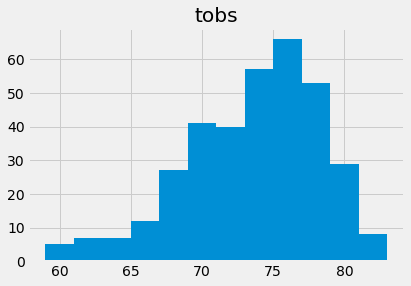

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Stat_results=session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.date.between(f'{end_d}', f'{Last_date}')).\
filter(Measurement.station==station_high)

Station_df=pd.DataFrame(Stat_results, columns=["date", "tobs"])
Station_df.hist(column="tobs", bins = 12)



## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
